In [1]:
# Standard library imports
import random
import time
import warnings
from collections import Counter

# Third-party library imports for data manipulation and linear algebra
import numpy as np
import pandas as pd

# NLP library
import nltk
from nltk.corpus import stopwords

# Machine learning libraries
from sklearn.decomposition import NMF
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Warning configuration (placed after all imports to ensure it applies to all relevant libraries)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)


C:\Users\jjzd8\AppData\Local\Temp\ipykernel_19700\1744736258.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


I will start with the results from the different runs. Comparing a train set, a validation set (20% of the original competition train set) and the final submission to the competition.

In [2]:
Dataset_scores = [
{"Name":"NMF with 10 clusters and selecting most common category", "Train score": 0.951, "Validation score":0.956, "Submission score": 0.948 },

{"Name":"NMF with 5 clusters and selecting most common category", "Train score": 0.948, "Validation score":0.960, "Submission score": 0.942 },

{"Name":"NMF with 5 clusters and predicting with 7 nearest neighbors", "Train score": 0.966, "Validation score":0.980, "Submission score": 0.952 },

{"Name":"Supervised algorithm (Multinomial Naive-Bayes, Full set)", "Train score": 1.000, "Validation score":0.983, "Submission score": 0.977 },

{"Name":"Supervised algorithm (Multinomial Naive-Bayes, 30% set)", "Train score": 1.000, "Validation score":0.940, "Submission score": None },
]

with pd.option_context('display.max_colwidth', None):
    # Convert the DataFrame to HTML and then display it
    display(HTML(pd.DataFrame(Dataset_scores).to_html()))

,Name,Train score,Validation score,Submission score
0,NMF with 10 clusters and selecting most common category,0.951,0.956,0.948
1,NMF with 5 clusters and selecting most common category,0.948,0.960,0.942
2,NMF with 5 clusters and predicting with 7 nearest neighbors,0.966,0.980,0.952
3,"Supervised algorithm (Multinomial Naive-Bayes, Full set)",1.000,0.983,0.977
4,"Supervised algorithm (Multinomial Naive-Bayes, 30% set)",1.000,0.940,NaN


In [3]:
ENABLE_SUBMISSIONS = False

def make_submission(articleIds, predictions, message):
    if ENABLE_SUBMISSIONS:
        pd.DataFrame({'ArticleId': articleIds, 'Category': predictions }).to_csv('submission.csv', index=False)
        !kaggle competitions submit -c learn-ai-bbc -f ./submission.csv -m "{message}"
    
def calculate_test_validation_scores(train_score, validation_score):
    print("This model gives a training accuracy of: {:.3f} and a validation accuracy of: {:.3f}".format(train_score,validation_score ))   
  

In [4]:
def show_words(text):
    """Retrieves a word, and plots the populartity per category
    """
    df_words = pd.DataFrame(zip(df_train.Category, df_train.Text.str.contains(text)))
    df_words.columns=["Category", "contains_word"]
    df = pd.melt(pd.pivot_table(df_words, columns='Category', aggfunc=sum))
    sns.barplot(df, y='value', x='Category')
    title = 'Articles with word "{}" in text per category'.format(text)
    plt.title(title)
    plt.show()

# Step 1: Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

### Dataset Utilization Strategy:

#### Overview:
Our analysis will incorporate three distinct datasets to ensure comprehensive evaluation and optimization of our models. The primary dataset, referred to as "Training," originates from the competition dataset. To enhance the robustness of our model, we will allocate 20% of the Training dataset to create a validation set.

#### Validation Set Purpose:
The validation set serves a critical role in our analysis by providing a mechanism to evaluate the efficacy of various model parameters against a 'held out' subset of data. This approach is instrumental in verifying that the chosen parameters maintain their effectiveness when confronted with new, unseen data. The iterative process of testing and refining parameters against the validation set is essential for identifying the optimal configuration for our models.

#### Final Model Submission:
Upon determining the most effective parameter settings, we will integrate both the validation and training sets for the final model refinement. This consolidated dataset will be used for the ultimate submission of our model, enabling it to predict the categories with enhanced accuracy and reliability.

#### Text Data Handling:
In scenarios involving text data, our strategy entails utilizing the entirety of the available articles. This comprehensive inclusion ensures that our model's vocabulary is sufficiently expansive to encompass all aspects of the data. Given the absence of definitive truth in our dataset, this approach mitigates the risk of inadvertently biasing the results.

In [5]:
df_train_and_val = pd.read_csv("data/BBC News Train.csv")
df_test = pd.read_csv("data/BBC News Test.csv")
df = pd.concat([df_train_and_val, df_test])

df_train, df_val = train_test_split(df_train_and_val, test_size=0.2, random_state=42)


In [6]:
df_train

,ArticleId,Text,Category
1166,1682,fuming robinson blasts officials england coach...,sport
1106,1950,huge rush for jet airways shares indian airlin...,business
538,623,voters don t trust politicians eight out of ...,politics
439,1431,dundee utd 4-1 aberdeen dundee united eased in...,sport
1478,1144,visa row mandarin made sir john the top civil ...,politics
...,...,...,...
1130,193,blair said he would stand down tony blair pr...,politics
1294,111,us trade gap hits record in 2004 the gap betwe...,business
860,833,tories pledge free sports lessons children wou...,politics
1459,2206,dance music not dead says fatboy dj norman coo...,entertainment


(1.0, 1000.0)

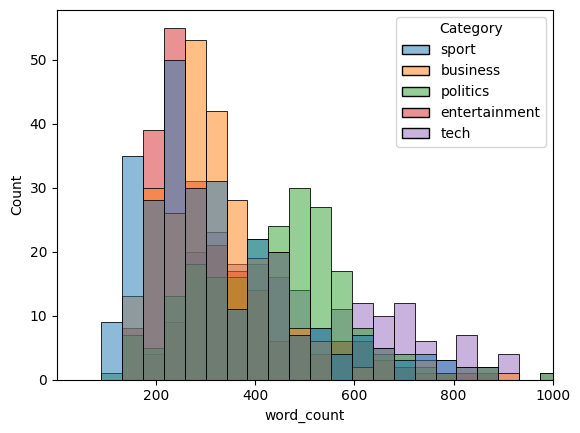

In [7]:
labels = df_train.Category.unique()
df_train['word_count'] = df_train['Text'].str.split().apply(len)
fig, ax = plt.subplots()
sns.histplot(df_train, x='word_count', hue='Category')
ax.set_xlim(1,1000)

In [8]:
df_train['words'] = df_train['Text'].str.split()
all_text = []
for text in df_train['words'].values:
    all_text.extend(text)
cnt = Counter(all_text)
cnt.most_common(5)

[('the', 28023), ('to', 13297), ('of', 10329), ('and', 9908), ('a', 9674)]

We will need to classify the documents based upon the words in the text. However, just a naive count, as the code above just shows the most common words in the language. 
These are called stopwords, and we can drop them:

In [9]:
stop_words = set(stopwords.words('english'))
all_words = []
for words_list in df_train['words']:
    for word in words_list:
        if word not in stop_words:
            all_words.append(word)
cnt = Counter(all_words)
cnt.most_common(5)

[('said', 2692), ('-', 1736), ('mr', 1567), ('would', 1365), ('also', 1139)]

In [10]:
for label in labels:
    all_text = []
    for text in df_train.loc[df_train.Category == label].Text:
        tokens = nltk.word_tokenize(text)
        for token in tokens:
            if token not in stop_words and len(token) > 1:
                all_text.append(token)

    cnt = Counter(all_text)
    print("Most common words in category: " +label+ " are: " + str(cnt.most_common(5)))

Most common words in category: sport are: [('said', 511), ('game', 292), ('england', 281), ('first', 275), ('world', 235)]
Most common words in category: business are: [('said', 860), ('us', 378), ('year', 310), ('mr', 309), ('would', 254)]
Most common words in category: politics are: [('said', 1162), ('mr', 852), ('would', 552), ('labour', 372), ('government', 356)]
Most common words in category: entertainment are: [('said', 503), ('film', 428), ('best', 354), ('also', 226), ('us', 218)]
Most common words in category: tech are: [('said', 799), ('people', 499), ('mobile', 296), ('mr', 274), ('new', 272)]


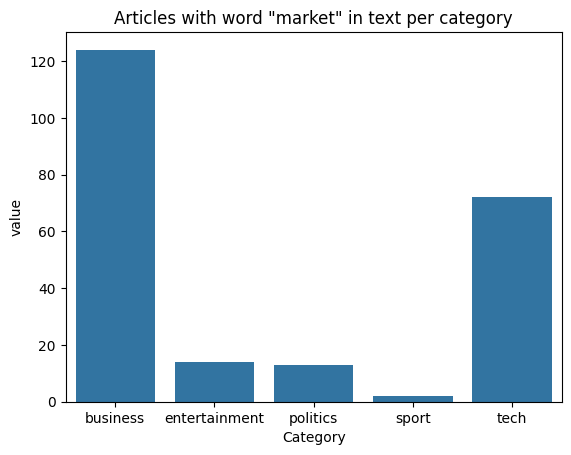

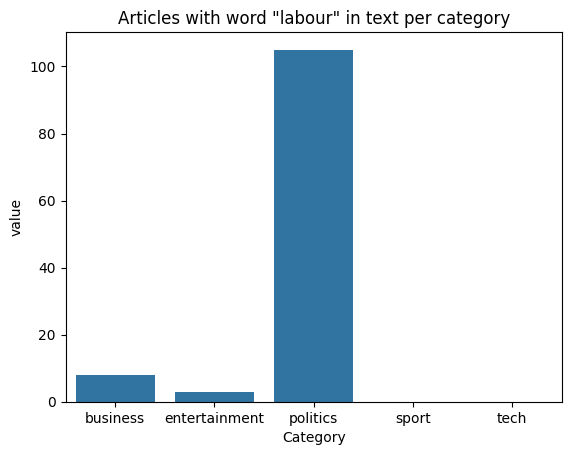

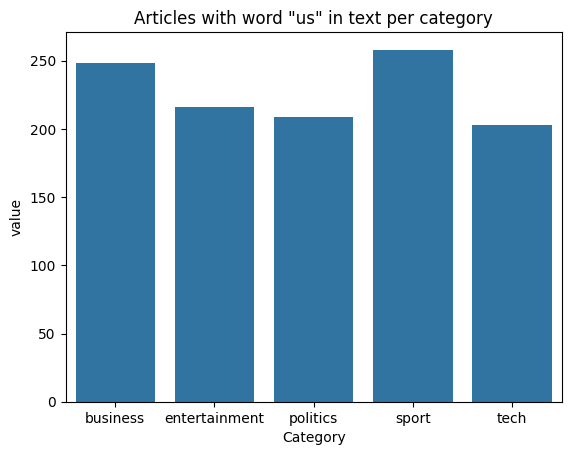

In [11]:
show_words("market")
show_words("labour")
show_words("us")

### Enhancing Document Context Analysis:

#### Preliminary Observations:
Our initial observations indicate that the presence of highly frequent, common words such as 'the' does not substantially contribute to discerning the unique context of a document. Although the exclusion of these terms offers some improvement, we encounter a residual challenge with relatively common words like 'said' or 'mister', which still do not provide significant contextual differentiation.

#### Utilization of TF-IDF Metric:
To address this challenge, we adopt the TF-IDF (Term Frequency-Inverse Document Frequency) metric, a sophisticated analytical tool that evaluates words based on their relative importance within a document and across a corpus. This dual consideration encompasses:

- **Term Frequency:** The prevalence of a word within a single document, highlighting its immediate significance.
- **Inverse Document Frequency:** This aspect evaluates the rarity of a term across all documents, assigning greater value to words that are uncommon in the broader dataset.

A word that appears frequently in a particular document but is rare in others is deemed highly relevant, receiving a significant TF-IDF score. Conversely, words that are widespread across many documents are assigned lower scores, reflecting their lesser discriminative power.

#### Balanced Weighting and Specificity:
The logarithmic scaling of Inverse Document Frequency ensures a nuanced weighting, especially for terms that occupy a middle ground in terms of frequency. For instance, a term like 'football' might be moderately common, neither ubiquitous across all documents nor exceedingly rare. This characteristic makes it an exemplary candidate for demonstrating the efficacy of TF-IDF in pinpointing terms that are particularly relevant in specific contexts, such as sports-related content.

#### Implementation Strategy:
Our approach will involve recalculating term scores within our documents using the TF-IDF metric, with a deliberate omission of stopwords to enhance precision. Furthermore, we will introduce a threshold, excluding terms that appear in more than 50% of the documents. This strategy ensures the exclusion of any term, regardless of its stopword status, that lacks the specificity required to contribute meaningful differentiation within our dataset's context.

In [12]:
# we are not using n-grams here. It didn't improve the score, takes longer, and only confirmed the general lessons of unsupervised vs supervised learning.
vectorizer = TfidfVectorizer(
    sublinear_tf=True, max_df=0.5, stop_words="english", min_df=0.01
)

X = vectorizer.fit_transform(df.Text)

X_train_and_val = vectorizer.transform(df_train_and_val.Text)
y_train_and_val = df_train_and_val['Category']

X_train = vectorizer.transform(df_train.Text)
y_train = df_train['Category']
X_val = vectorizer.transform(df_val.Text)
y_val = df_val['Category']
X_test = vectorizer.transform(df_test.Text)

## Step 2: Training a model and converting a highest embedding to a forecast

In [13]:
def plot_top_words(model, feature_names, n_top_words):
    """
    Plots the top words for each topic in a topic model.

    This function creates a bar plot for each topic in the given topic model. Each bar plot
    displays the 'n_top_words' most important words for the topic, based on their weights.
    The plots are arranged in a 2x5 grid, and each plot shows the top words in descending order
    of importance.

    Parameters:
    - model: The trained topic model (e.g., NMF). It should have a 'components_' attribute, 
      which is a 2D array where each row represents a topic and each column represents a word's
      importance in that topic.
    - feature_names: A list or array of feature names that correspond to the columns in the
      model's 'components_' attribute. Typically, this would be the feature names obtained 
      from a vectorizer used in the topic modeling process.
    - n_top_words (int): The number of top words to display for each topic.

    The function generates a matplotlib figure with subplots, each showing the top words for 
    a topic. The words are displayed in a horizontal bar chart, with the length of each bar 
    representing the weight of the word in the topic.

    Example usage:
    tfidf_feature_names = vectorizer.get_feature_names_out()
    plot_top_words(nmf, tfidf_feature_names, 20)

    """
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle("Topics in NMF model (Frobenius norm)", fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


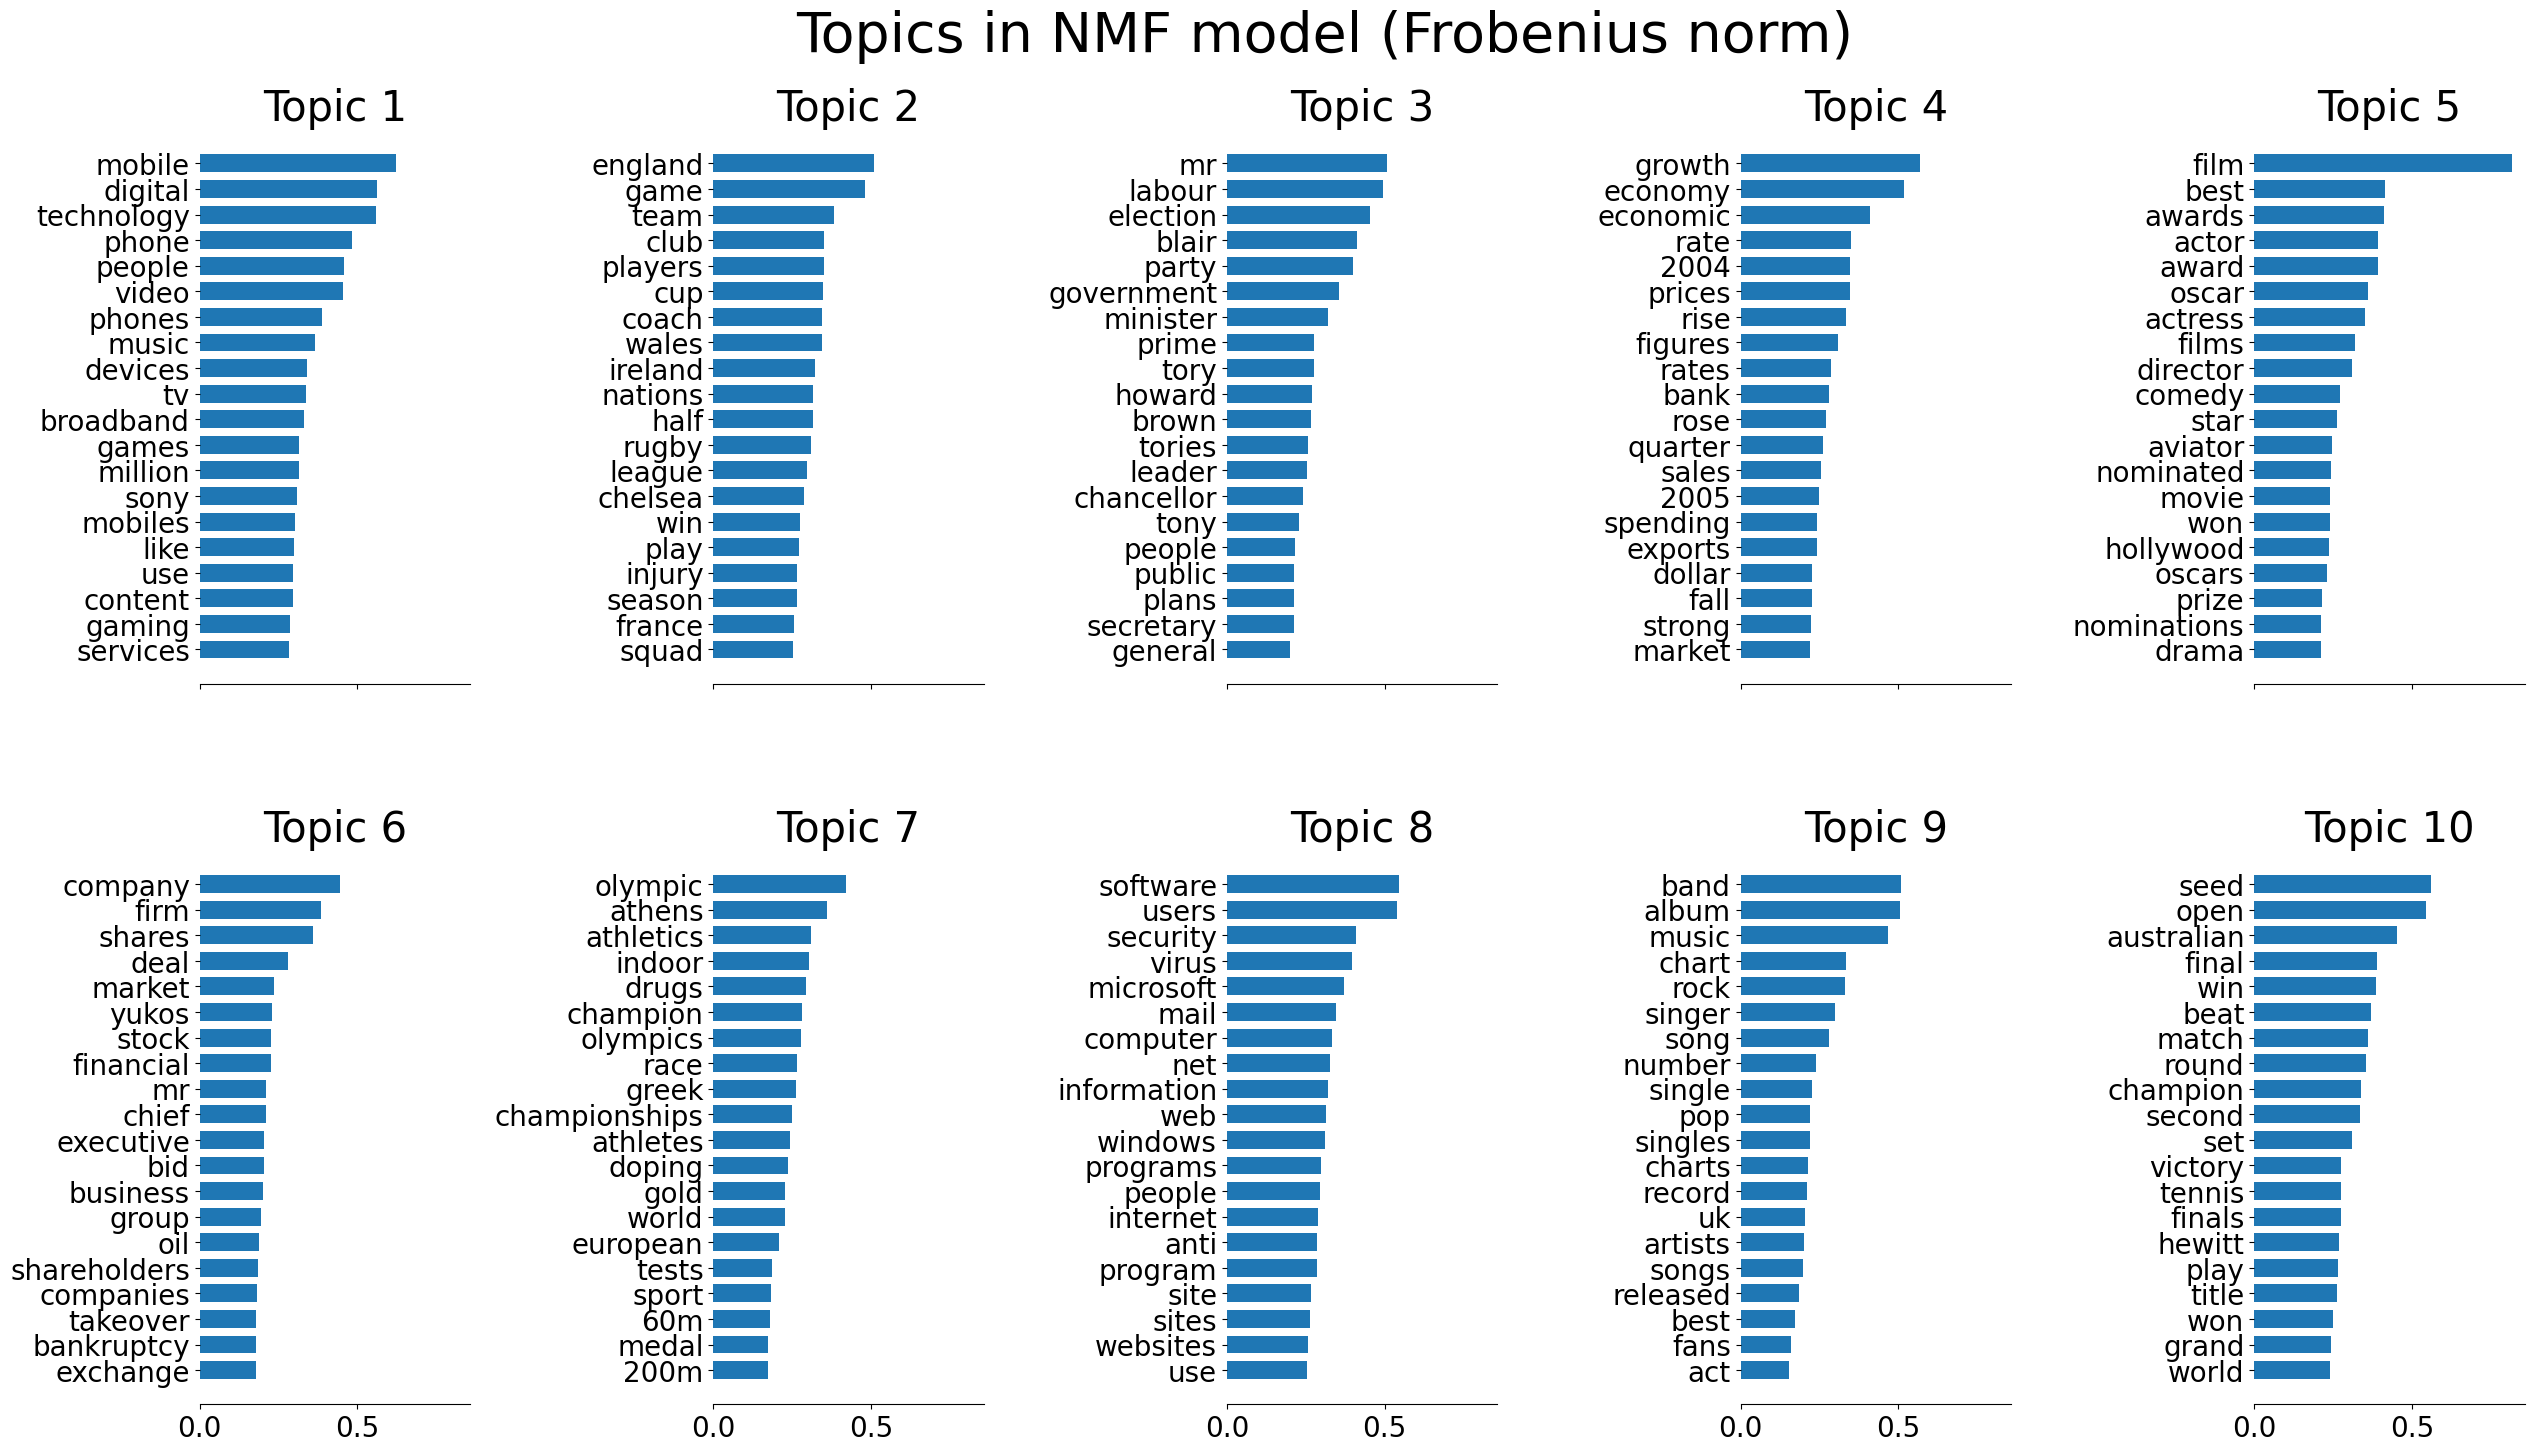

In [14]:
n_components = 10 # i have chosen 10 so with 5 categories, on average there can be two types of articles
nmf_10 = NMF(
    n_components=n_components,
    random_state=1,
    init='nndsvd',
).fit(X)
tfidf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(
    nmf_10, tfidf_feature_names, 20)

In [15]:
predictions = np.argmax(nmf_10.transform(X_train), axis=1)

mapping_dict = {}
for i in range(n_components):
    mask = predictions==i
    mapping_dict[str(i)] = df_train.Category[mask].mode()[0]
    
mapping_dict

{'0': 'tech',
 '1': 'sport',
 '2': 'politics',
 '3': 'business',
 '4': 'entertainment',
 '5': 'business',
 '6': 'sport',
 '7': 'tech',
 '8': 'entertainment',
 '9': 'sport'}

In [16]:
predictions_from_train = []
for i in range(len(predictions)):
    predictions_from_train.append(mapping_dict[str(predictions[i])])

validation = np.argmax(nmf_10.transform(X_val), axis=1)
predictions_from_validation = []
for i in range(len(validation)):
    predictions_from_validation.append(mapping_dict[str(validation[i])])

test_score = sum(df_train.Category == predictions_from_train)/len(predictions_from_train)
validation_score = sum(df_val.Category == predictions_from_validation)/len(predictions_from_validation)

calculate_test_validation_scores(test_score, validation_score)

This model gives a training accuracy of: 0.951 and a validation accuracy of: 0.956


In [17]:
# spot checking classifications
mask = predictions==3
print(f"The category to check: {mapping_dict[str(3)]}")
print(df_train[mask].Text[:5])
mask = predictions==9
print(f"The category to check: {mapping_dict[str(9)]}")
print(df_train[mask].Text[:5])

The category to check: business
1022    bank opts to leave rates on hold the bank of e...
513     house prices suffer festive fall uk house pric...
254     europe asks asia for euro help european leader...
566     japan turns to beer alternatives japanese brew...
174     manufacturing recovery  slowing  uk manufactur...
Name: Text, dtype: object
The category to check: sport
661     williams battles to aussie title serena willia...
904     mauresmo opens with victory in la amelie maure...
1471    ferrero eyes return to top form former world n...
583     clijsters set for february return tennis star ...
724     veteran martinez wins thai title conchita mart...
Name: Text, dtype: object


In [18]:
predictions_from_highest_loading = np.argmax(nmf_10.transform(X_train_and_val), axis=1)

mapping_dict = {}
for i in range(n_components):
    mask = predictions_from_highest_loading==i
    mapping_dict[str(i)] = df_train_and_val.Category[mask].mode()[0]

In [19]:
loadings_for_test_set = np.argmax(nmf_10.transform(X_test), axis=1)
prediction_for_test_set = []

for i in range(len(loadings_for_test_set)):
    prediction_for_test_set.append(mapping_dict[str(loadings_for_test_set[i])])
    
make_submission(df_test.ArticleId, prediction_for_test_set, "NMF with 10 clusters and selecting most common category")  

## Step 3: Finding optimal hyper parameters

#### Determining Key Parameters:
In the quest to optimize our article embedding process, the pivotal factor under consideration is the number of components utilized for embedding the articles. This aspect is crucial as it directly influences the granularity and effectiveness of the embedding, impacting our ability to differentiate between articles.

#### Hypothesis on Component Optimization:
My hypothesis posits that an optimal number of components exists, which surpasses the total number of categories. This surplus is necessary to adequately capture the diversity within individual categories, allowing for a nuanced representation of various article types under a single category. However, it's important to acknowledge the existence of an upper limit to this number. For the purpose of this analysis, we will operate under the assumption that accommodating up to five distinct article types per category should suffice.

#### Influence of Dataset Size on Accuracy:
Another critical consideration is the relationship between dataset size and model accuracy. Expanding the dataset size is anticipated to enhance model performance progressively. This improvement is attributed to the enrichment of the model's vocabulary, enabling it to comprehend and interpret a more comprehensive array of nuances within the text. The addition of more words and phrases with each dataset increment allows for a more detailed and accurate representation of the content, thereby improving the overall quality of the embedding process.

In [20]:

def get_accuracy_from_encodings(n_components, sample):
    """
    Calculates the accuracy of non-negative matrix factorization (NMF) for clustering 
    by mapping the clusters to the most frequent category in each cluster.

    This function first randomly samples a subset of the dataset, then applies NMF to 
    this subset to identify 'n_components' number of clusters. Each cluster is then 
    mapped to the most common category (mode) found in that cluster within the training 
    set. Finally, the function calculates the accuracy as the proportion of data points 
    in the entire training set whose predicted cluster matches their actual category.

    Parameters:
    - n_components (int): The number of components (clusters) to use for NMF.
    - sample (float): The fraction of the dataset to sample for training the NMF model.

    Requires:
    - A predefined training dataset 'X_train'.
    - A predefined DataFrame 'df_train' with a 'Category' column.

    Returns:
    - float: The accuracy of the model, computed as 1 minus the proportion of incorrectly 
      mapped categories in 'df_train'.

    Note:
    - This function sets a fixed seed for random operations to ensure reproducibility.
    - The function assumes that 'X', 'X_train', and 'df_train' are available in the scope 
      where the function is called.
    """
    random.seed(42)
    dataset = X_train[random.sample(range(X_train.shape[0]), int(sample*X_train.shape[0])),]
    start_time = time.time()
    nmf = NMF(
        n_components=n_components,
        random_state=1,
        init='nndsvd',
    ).fit(dataset)
    end_time = time.time()
    predictions = np.argmax(nmf.transform(X_train), axis=1)

    mapping_dict = {}
    for i in range(n_components):
        mask = predictions==i
        mapping_dict[str(i)] = df_train.Category[mask].mode()[0]

    mapped_clusters = [mapping_dict[str(i)] for i in predictions]
    accuracy = 1 - np.sum(mapped_clusters != df_train.Category)/len(mapped_clusters)
    return end_time - start_time, accuracy

# Create combinations of n_component and sample_share
combinations = [(n, s) for n in [5, 8, 12, 18, 25] for s in [0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1]]

results_list = []

with warnings.catch_warnings():
    # We can expect warnings about convergence. Let's ignore them in this context.
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    for n_component, sample_share in combinations:
        time_taken, accuracy = get_accuracy_from_encodings(n_component, sample_share)
        result = {
            "N_component": n_component, 
            "Sample_share": sample_share, 
            "Accuracy": accuracy, 
            "Time": time_taken
        }
        results_list.append(result)

# Create a DataFrame from the list of dictionaries
results_df_nmf = pd.concat([pd.DataFrame([result]) for result in results_list], ignore_index=True)

Text(0.5, 1.0, 'Train Accuracy with a combination of component and dataset size')

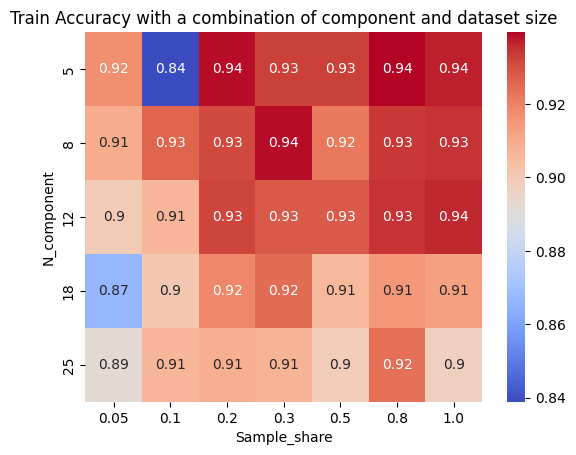

In [21]:
# Create pivot table
pivot_df_acc = results_df_nmf.pivot(index='N_component', columns='Sample_share', values='Accuracy')
sns.heatmap(pivot_df_acc, annot=True, cmap='coolwarm')
plt.title('Train Accuracy with a combination of component and dataset size')

Text(0.5, 1.0, 'Time Required for Varying test Accuracy Levels by Number of Components')

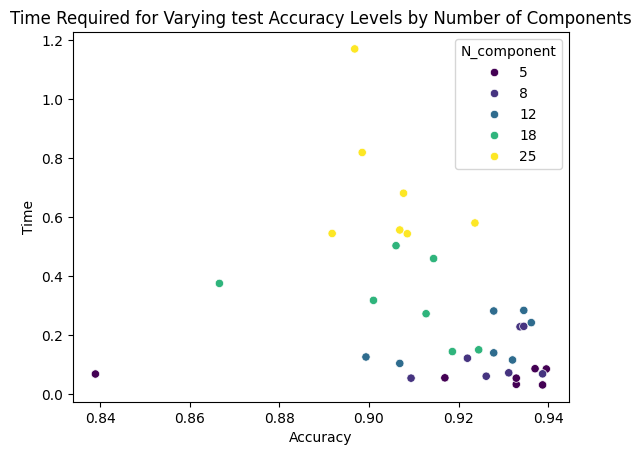

In [22]:
sns.scatterplot(data=results_df_nmf, x='Accuracy', y='Time', hue='N_component', palette='viridis')
plt.title("Time Required for Varying test Accuracy Levels by Number of Components")

### Evaluation of Model Performance:

#### Initial Findings:
Contrary to initial expectations, the simplicity of our model does not hinder its performance; rather, it exhibits a surprisingly high level of accuracy. Utilizing merely 5% of the available data and limiting the number of clusters to the count of categories, the model achieves an impressive 83% accuracy. 

#### Impact of Cluster Quantity:
Initially, increasing the number of clusters beyond the number of categories yields a modest improvement of approximately 5% in accuracy. This advantage, however, diminishes as the dataset size is doubled. The transient nature of this benefit suggests that while additional clusters may provide initial gains by capturing more nuanced distinctions within the data, the scalability of this advantage is limited by the increasing diversity of the larger dataset.

#### Optimal Configuration:
A pivotal shift occurs as the dataset expands to encompass 30% of its total volume. At this juncture, a model configuration that aligns the number of clusters with the number of categories emerges as the most effective approach, surpassing alternative configurations in performance. Remarkably, this model maintains its lead and continues to excel as further data is incorporated. 

In [23]:
# This is our best configuration
nmf_5 = NMF(
        n_components=5,
        random_state=1,
        init='nndsvd',
    ).fit(X)

In [24]:
predictions_5_train = np.argmax(nmf_5.transform(X_train), axis=1)

mapping_dict = {}
for i in range(5):
    mask = predictions_5_train==i
    mapping_dict[str(i)] = df_train.Category[mask].mode()[0]

predictions_5_train_results = []
for i in range(len(predictions_5_train)):
    predictions_5_train_results.append(mapping_dict[str(predictions_5_train[i])])


predictions_5_val = np.argmax(nmf_5.transform(X_val), axis=1)
predictions_5_val_results = []
for i in range(len(predictions_5_val)):
    predictions_5_val_results.append(mapping_dict[str(predictions_5_val[i])])

test_score = sum(df_train.Category == predictions_5_train_results)/len(predictions_5_train_results)
validation_score = sum(df_val.Category == predictions_5_val_results)/len(predictions_5_val_results)

calculate_test_validation_scores(test_score, validation_score)

This model gives a training accuracy of: 0.948 and a validation accuracy of: 0.960


In [25]:
predictions_test = np.argmax(nmf_5.transform(X_test), axis=1)

new_pred = []
for i in range(len(predictions_test)):
    new_pred.append(mapping_dict[str(predictions_test[i])])
    
make_submission(df_test.ArticleId, new_pred, "NMF with 5 clusters and selecting most common category")  

## Step 5: Model improvements

### Refinement of Naive Model Approach:

#### Limitation of Current Model:
A significant limitation of our current naive model lies in its exclusive reliance on the largest loading factor to determine the document's category. This approach results in the dismissal of all other loading factors, which could potentially hold valuable information for more nuanced categorization.

#### Proposed Solution:
To address this shortfall, I propose a more holistic utilization of the loading factors by incorporating all available loadings in the categorization process. The strategy involves employing a K nearest neighbors (KNN) algorithm, which leverages the spectrum of loading factors to identify the 'K' closest documents within the embedding space.

In [26]:
for i in [1,3,5,7,9,11]:
    
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(nmf_5.transform(X_train), df_train.Category)
    
    print("neighbors: {} has validation accuracy: {}".format(i,neigh.score(nmf_5.transform(X_val), y_val)))

neighbors: 1 has validation accuracy: 0.9765100671140939
neighbors: 3 has validation accuracy: 0.9731543624161074
neighbors: 5 has validation accuracy: 0.9765100671140939
neighbors: 7 has validation accuracy: 0.9798657718120806
neighbors: 9 has validation accuracy: 0.9731543624161074
neighbors: 11 has validation accuracy: 0.9731543624161074


In [27]:
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(nmf_5.transform(X_train), df_train.Category)

calculate_test_validation_scores(neigh.score(nmf_5.transform(X_train), y_train), neigh.score(nmf_5.transform(X_val), y_val))

This model gives a training accuracy of: 0.966 and a validation accuracy of: 0.980


In [28]:
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(nmf_5.transform(X_train_and_val), df_train_and_val.Category)
neighbor_predictions = neigh.predict(nmf_5.transform(X_test))

In [29]:
make_submission(df_test.ArticleId, neighbor_predictions, "NMF with 5 clusters and predicting with 7 nearest neighbors")  

Using the NMF with k-nearest classifier with 7 neighbors gives us an test accuracy of 98%

## Step 6: Compare with supervised learning

In our current methodology, we have employed the Multinomial Naive Bayes (MNB) classifier, a choice grounded in its compatibility with the nature of our data—specifically, the raw word counts derived from the text. This approach aligns with the recommended usage outlined in the classifier's documentation. Although tf-idf vectorization is a viable alternative and is commonly used in practice, our trials indicated a slight decrease in performance (approximately 0.5%) compared to using raw counts.

### Utilization of CountVectorizer:

To further refine our model, we have adopted the CountVectorizer for text vectorization, with specific parameters tailored to optimize our dataset's unique characteristics. By setting max_df to 0.5, we limit the vocabulary to terms appearing in less than 50% of the documents, effectively filtering out excessively common words. The exclusion of English stopwords is another critical step, reducing noise and focusing on more meaningful content within the text.

### Enhancement with N-Grams:

A significant enhancement in our vectorization strategy is the inclusion of n-grams, ranging from unigrams to four-grams (ngram_range=(1, 4)). This approach ensures that phrases such as "Manchester United" are treated as single entities within the vocabulary, thus preserving their contextual significance. The incorporation of n-grams has shown to improve classification accuracy by capturing the nuanced meaning conveyed through specific term combinations.

In [30]:
mnb = MultinomialNB()
# we are using the raw word counts again. This is according to the documentation the intended use. TfIdf also works fine in practice, but gave a .5% lower score. 
# We also use n-grams here, this makes sure that a term like "Manchester United" get's it's own entry in the vocabulary, this helped a bit in classfication.
vectorizer = CountVectorizer(max_df=0.5, stop_words="english",ngram_range=(1, 4))
X_train_cnt = vectorizer.fit_transform(df_train.Text)
X_val_cnt = vectorizer.transform(df_val.Text)

mnb.fit(X_train_cnt, y_train)
calculate_test_validation_scores(mnb.score(X_train_cnt, y_train), mnb.score(X_val_cnt, y_val))

This model gives a training accuracy of: 1.000 and a validation accuracy of: 0.983


In [31]:
mnb = MultinomialNB()
X_train_cnt_subset, _, y_train_subset, _ = train_test_split(X_train_cnt, y_train, test_size=0.7, random_state=42)

mnb.fit(X_train_cnt_subset, y_train_subset)
calculate_test_validation_scores(mnb.score(X_train_cnt_subset, y_train_subset), mnb.score(X_val_cnt, y_val))

This model gives a training accuracy of: 1.000 and a validation accuracy of: 0.940


In [32]:
mnb = MultinomialNB()
vectorizer = CountVectorizer(max_df=0.5, stop_words="english",ngram_range=(1, 4)).fit(df.Text)
X_train_and_val_cnt = vectorizer.transform(df_train_and_val.Text)
mnb.fit(X_train_and_val_cnt, df_train_and_val.Category)
X_test = vectorizer.transform(df_test.Text)
mnb_predictions = mnb.predict(X_test)

In [33]:
make_submission(df_test.ArticleId, mnb_predictions, "Supervised algorithm (MNB)")  

## Discussion

### Direct Application of Multinomial Naive Bayes:

The implementation of a Multinomial Naive Bayes (MNB) classifier directly on the text data has demonstrated superior performance compared to models that rely on dimension reduction techniques. The inherent strength of MNB in handling categorical data and its ability to accommodate the high-dimensional feature space typical of text data contribute to its enhanced accuracy in classification tasks.

### Overfitting Concerns:

Despite its advantages, the MNB model is not without its limitations. One notable concern is its propensity to overfit the training data. Given its 'powerful' nature, the model can sometimes capture noise or idiosyncrasies in the training dataset as significant patterns, leading to a model that performs exceptionally well on training data but fails to generalize to unseen data effectively.

### Larger Dataset Requirement:

Another critical aspect of the MNB model is its dependency on substantial dataset sizes. The model's performance is significantly influenced by the volume of data available for training. This characteristic is particularly evident when the dataset size is reduced; while an unsupervised learning model might exhibit stability in its results even with reduced data, the MNB model shows a pronounced decline in accuracy.

### Stability of Unsupervised Learning with Reduced Data:

In contrast, unsupervised learning models, which do not rely on labelled data, demonstrate remarkable resilience in the face of reduced dataset sizes. Their ability to uncover underlying patterns and structures in the data without the guidance of predefined labels enables them to maintain consistent performance levels, even when the quantity of data is substantially diminished.